<a href="https://colab.research.google.com/github/MCygert/preparing_for_tensorflow_certificate/blob/main/05_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning - fine tuning


In [21]:
!nvidia-smi

Sun Jan  9 14:29:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   2605MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-09 11:45:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-09 11:45:16 (121 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [6]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


### Download data

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2022-01-09 11:49:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   285MB/s    in 0.6s    

2022-01-09 11:49:37 (285 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [8]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [9]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [11]:
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, image_size=IMG_SIZE, label_mode="categorical")

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, image_size=IMG_SIZE, label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [15]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.02015305e+02 3.40153046e+01 3.30153046e+01]
   [1.07494904e+02 3.94948997e+01 3.84948997e+01]
   [1.07010201e+02 3.90102043e+01 3.80102043e+01]
   ...
   [2.68571873e+01 9.85718632e+00 1.58571863e+01]
   [2.92142735e+01 1.22142725e+01 1.82142735e+01]
   [2.49285011e+01 7.92850161e+00 1.39285021e+01]]

  [[1.03357140e+02 3.53571396e+01 3.43571396e+01]
   [1.02352036e+02 3.43520393e+01 3.33520393e+01]
   [1.04270409e+02 3.62704086e+01 3.52704086e+01]
   ...
   [2.78418598e+01 1.08418598e+01 1.68418598e+01]
   [2.90714149e+01 1.20714149e+01 1.80714149e+01]
   [2.82806396e+01 1.12806396e+01 1.72806396e+01]]

  [[1.04627548e+02 3.72704048e+01 3.56275482e+01]
   [1.02428574e+02 3.50714264e+01 3.34285698e+01]
   [1.05811226e+02 3.78112259e+01 3.64744911e+01]
   ...
   [2.77397995e+01 1.11683722e+01 1.69540863e+01]
   [2.51122646e+01 8.54083729e+00 1.43265514e+01]
   [3.14286766e+01 1.48572474e+01 2.06429615e+01]]

  ...

  [[2.20107544e+02 2.12898376e+02 1.15827164e+02]
   [2

In [20]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
print(f"Shape after passing inputs throug base model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_avaregae_pooling_layer")(x)
print(f"Shape after global avareage pooling 2D {x.shape}")

outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)
model_0 = tf.keras.Model(inputs, outputs)

# Compile
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
# Fit
history_model_0 = model_0.fit(train_data_10_percent, steps_per_epoch=len(train_data_10_percent), epochs=5, validation_data=test_data_10_percent, validation_steps=len(test_data_10_percent), callbacks=[create_tensorboard_callback("transfer_learning", "10_percent")])

Shape after passing inputs throug base model: (None, 7, 7, 1280)
Shape after global avareage pooling 2D (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20220109-125521
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 11s 258ms/step - loss: 1.9718 - accuracy: 0.3867 - val_loss: 1.4158 - val_accuracy: 0.6724
Epoch 2/5
24/24 [==============================] - 5s 209ms/step - loss: 1.1891 - accuracy: 0.7413 - val_loss: 0.9618 - val_accuracy: 0.7808
Epoch 3/5
24/24 [==============================] - 5s 209ms/step - loss: 0.8627 - accuracy: 0.7973 - val_loss: 0.7799 - val_accuracy: 0.8108
Epoch 4/5
24/24 [==============================] - 5s 210ms/step - loss: 0.7082 - accuracy: 0.8347 - val_loss: 0.6861 - val_accuracy: 0.8216
Epoch 5/5
24/24 [==============================] - 5s 208ms/step - loss: 0.5963 - accuracy: 0.8667 - val_loss: 0.6246 - val_accuracy: 0.8288


In [22]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")


--2022-01-09 14:31:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  48.1MB/s    in 2.7s    

2022-01-09 14:31:20 (48.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"


In [27]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [56]:
# Setup data loaders
IMG_SIZE=(224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
print(tf.__version__)

2.7.0


In [34]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
])

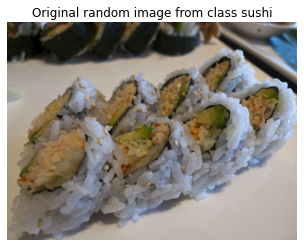

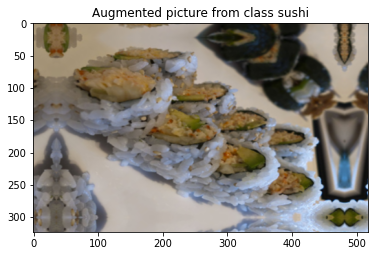

In [52]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)


# Now lets plot our augmented image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.title(f"Augmented picture from class {target_class}")
plt.imshow(tf.squeeze(augmented_img) / 255.)

## Model 1:

In [57]:
# Setup input shape and base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape,
                      name = 'input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data))
                                )

Epoch 1/5
3/3 [==============================] - 7s 1s/step - loss: 2.4110 - accuracy: 0.1286 - val_loss: 2.2146 - val_accuracy: 0.1990
Epoch 2/5
3/3 [==============================] - 2s 685ms/step - loss: 2.2304 - accuracy: 0.1714 - val_loss: 2.0933 - val_accuracy: 0.2878
Epoch 3/5
3/3 [==============================] - 2s 692ms/step - loss: 1.9813 - accuracy: 0.3143 - val_loss: 1.9875 - val_accuracy: 0.3602
Epoch 4/5
3/3 [==============================] - 2s 681ms/step - loss: 1.8215 - accuracy: 0.4714 - val_loss: 1.9060 - val_accuracy: 0.4046
Epoch 5/5
3/3 [==============================] - 2s 683ms/step - loss: 1.6884 - accuracy: 0.6143 - val_loss: 1.8291 - val_accuracy: 0.4441


## Model 2

In [62]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent")
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [63]:
IMG_SIZE=(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent, label_mode='categorical', image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='categorical', image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [71]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
                                preprocessing.RandomFlip('horizontal'),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2),
])
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_averge_pooling_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [74]:
# Make all layers trainable
base_model.trianable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

# Recompile 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [75]:
model_2.fit(train_data_10_percent,
            epochs=10,
            validation_data=test_data,
            validation_steps=len(test_data))

Epoch 1/10
24/24 [==============================] - 14s 355ms/step - loss: 2.0412 - accuracy: 0.3227 - val_loss: 1.5213 - val_accuracy: 0.6380
Epoch 2/10
24/24 [==============================] - 7s 278ms/step - loss: 1.3805 - accuracy: 0.6800 - val_loss: 1.0885 - val_accuracy: 0.7452
Epoch 3/10
24/24 [==============================] - 6s 268ms/step - loss: 1.0725 - accuracy: 0.7347 - val_loss: 0.8800 - val_accuracy: 0.7788
Epoch 4/10
24/24 [==============================] - 6s 265ms/step - loss: 0.9229 - accuracy: 0.7520 - val_loss: 0.7834 - val_accuracy: 0.7932
Epoch 5/10
24/24 [==============================] - 6s 261ms/step - loss: 0.7942 - accuracy: 0.8093 - val_loss: 0.7132 - val_accuracy: 0.8032
Epoch 6/10
24/24 [==============================] - 6s 255ms/step - loss: 0.7164 - accuracy: 0.8147 - val_loss: 0.6638 - val_accuracy: 0.8112
Epoch 7/10
24/24 [==============================] - 6s 249ms/step - loss: 0.6621 - accuracy: 0.8213 - val_loss: 0.6361 - val_accuracy: 0.8100
Epoch